In [1]:
%matplotlib inline

import math
import copy
import numpy as np
from scipy import stats
from itertools import permutations
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn import neighbors
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, learning_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import xgboost as xgb
import pickle

In [ ]:
import keras

In [2]:
sensor_data_39 = pd.read_csv("D:\\p_eaglesense\\eaglesense\\data\\topviewkinect\\3039\\android_sensor_data.csv")

In [3]:
sensor_data_41 = pd.read_csv("D:\\p_eaglesense\\eaglesense\\data\\topviewkinect\\3041\\android_sensor_data.csv")

In [4]:
sensor_data_39.head()

,frame_id,depth_time,addr,time,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,...,linear_accel_x,linear_accel_y,linear_accel_z,gravity_x,gravity_y,gravity_z,rotation_x,rotation_y,rotation_z,label
0,0,0,10.32.114.115:38932,0.00000,-0.13,0.128,9.758,0.0,8978685.0,0.0,...,0.0,0.0,0.0,6.595770e+12,0.0,50549.5625,0.0,50552.78125,0.0,0
1,0,0,10.32.114.115:38932,0.00482,-0.13,0.128,9.758,0.0,8978685.0,0.0,...,0.0,0.0,0.0,6.595770e+12,0.0,50549.5625,0.0,50552.78125,0.0,0
2,0,0,10.32.114.115:38932,0.00961,-0.13,0.128,9.758,0.0,8978685.0,0.0,...,0.0,0.0,0.0,6.595770e+12,0.0,50549.5625,0.0,50552.78125,0.0,0
3,0,0,10.32.114.115:38932,0.01348,-0.13,0.128,9.758,0.0,8978685.0,0.0,...,0.0,0.0,0.0,6.595770e+12,0.0,50549.5625,0.0,50552.78125,0.0,0
4,0,0,10.32.114.115:38932,0.01831,-0.13,0.128,9.758,0.0,8978685.0,0.0,...,0.0,0.0,0.0,6.595770e+12,0.0,50549.5625,0.0,50552.78125,0.0,0


In [5]:
sensor_data_41.head()

,frame_id,depth_time,addr,time,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,...,linear_accel_x,linear_accel_y,linear_accel_z,gravity_x,gravity_y,gravity_z,rotation_x,rotation_y,rotation_z,label
0,0,0,10.32.114.115:50125,0.00476,-0.090,0.131,9.725,0.000,0.002,0.001,...,-0.013,-0.011,-0.020,-0.121,0.119,9.805,-0.001,0.009,0.749,0
1,0,0,10.32.114.115:50125,0.00956,-0.145,0.124,9.739,0.001,0.002,-0.000,...,-0.025,0.006,0.014,-0.121,0.119,9.805,-0.001,0.009,0.749,0
2,0,0,10.32.114.115:50125,0.01432,-0.111,0.128,9.727,0.001,-0.000,0.000,...,-0.025,0.006,0.014,-0.121,0.119,9.805,-0.001,0.009,0.749,0
3,0,0,10.32.114.115:50125,0.01908,-0.128,0.112,9.706,-0.001,0.001,0.000,...,0.009,0.010,0.002,-0.121,0.119,9.805,-0.001,0.009,0.749,0
4,0,0,10.32.114.115:50125,0.02385,-0.116,0.114,9.710,-0.001,0.001,0.000,...,0.004,-0.004,-0.015,-0.121,0.119,9.805,-0.001,0.009,0.749,0


In [6]:
pd.unique(sensor_data_39["label"]), pd.unique(sensor_data_41["label"])

(array([0, 1, 2], dtype=int64), array([0, 1, 2], dtype=int64))

In [7]:
def show_data_distribution(data):
    labels = data["label"].values
    labels_count = np.bincount(labels)
    print("rest", labels_count[0])
    print("inward", labels_count[1])
    print("outward", labels_count[2])
    print("all", len(labels))

In [8]:
show_data_distribution(sensor_data_39)

rest 33957
inward 15136
outward 16260
all 65353


In [9]:
show_data_distribution(sensor_data_41)

rest 29175
inward 15846
outward 18367
all 63388


In [44]:
def make_sliding_window(data, frame_size, step_size):
    
    frames = []

    start_index = 0

    while start_index + frame_size < len(data):
        frame_data = data.iloc[start_index:start_index+frame_size]
        frames.append(frame_data)
        start_index += step_size
            
    return frames

In [45]:
# @ 200 Hz
frame_size = 20
step_size = 20
window_size = 200

In [46]:
sensor_data_39_frames = make_sliding_window(sensor_data_39, frame_size, step_size)

In [47]:
sensor_data_41_frames = make_sliding_window(sensor_data_41, frame_size, step_size)

In [48]:
len(sensor_data_39_frames)

3267

In [49]:
len(sensor_data_41_frames)

3169

In [16]:
features_length = 7 + 10 + 10 + 5

In [17]:
columns_X_fft = list(range(features_length))
columns_y_fft = ["label"]

In [18]:
columns_fft = copy.copy(columns_X_fft)
columns_fft.extend(columns_y_fft)

In [19]:
def compute_features(data_frames, frame_size, window_size):
    
    features_df = pd.DataFrame(columns=columns_fft)
    
    start_index = 0
    frames_in_window = int(window_size / frame_size)
    S_t_0 = None
    
    while start_index <= len(data_frames)-1-frames_in_window:
        print(".", end='')

        S_t_1_frames = data_frames[start_index:start_index+frames_in_window]
        S_t_1_spectra = []
        S_t_1_labels = []
        
        for frame in S_t_1_frames:
            F_x = np.abs(np.fft.rfft(frame["linear_accel_x"]))

            hamming = np.hamming(len(F_x))

            F_x = F_x * hamming
            F_x = F_x[1:]

            F_y = np.abs(np.fft.rfft(frame["linear_accel_y"]))
            F_y = F_y * hamming
            F_y = F_y[1:]

            F_z = np.abs(np.fft.rfft(frame["linear_accel_z"]))
            F_z = F_z * hamming
            F_z = F_z[1:]

            F_i = np.array([max(x_i, y_i, z_i) for x_i, y_i, z_i in zip(F_x, F_y, F_z)])
            S_t_1_spectra.append(F_i)
            S_t_1_labels.extend(frame["label"])
        
        S_t_1 = np.mean(S_t_1_spectra, axis=0)
        
        # compute features
        if S_t_0 is not None:
            ft_mean = np.mean(S_t_1)
            ft_median = np.median(S_t_1)
            ft_std = np.std(S_t_1)
            ft_sum = np.sum(S_t_1)
            ft_min = np.min(S_t_1)
            ft_max = np.max(S_t_1)
            ft_range = ft_max - ft_max
            ft_der = S_t_1 - S_t_0
            ft_ratios = S_t_1 / S_t_0
            ft_peaks = -np.partition(-S_t_1, 5)[:5]

            label = stats.mode(S_t_1_labels).mode[0]

            ft_extended = [ft_mean, ft_median, ft_std, ft_sum, ft_min, ft_max, ft_range]
            ft_extended.extend(ft_der)
            ft_extended.extend(ft_ratios)
            ft_extended.extend(ft_peaks)
            ft_extended.append(label)

            ft_data = pd.DataFrame(data=[ft_extended], columns=columns_fft)
            features_df = features_df.append(ft_data, ignore_index=True)
        
        S_t_0 = copy.copy(S_t_1)
        start_index += 1
        
    return features_df

In [20]:
sensor_data_39_df = compute_features(sensor_data_39_frames, frame_size, window_size)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [21]:
sensor_data_41_df = compute_features(sensor_data_41_frames, frame_size, window_size)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [22]:
len(sensor_data_39_df), len(sensor_data_41_df)

(3256, 3158)

In [23]:
sensor_data_fft = pd.DataFrame(columns=columns_fft)

In [24]:
sensor_data_fft = sensor_data_fft.append(sensor_data_39_df, ignore_index=True)

In [25]:
sensor_data_fft = sensor_data_fft.append(sensor_data_41_df, ignore_index=True)

In [26]:
sensor_data_fft["label"] = sensor_data_fft["label"].astype(int)

In [27]:
sensor_data_fft.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,label
0,0.032044,0.030940,0.019976,0.320441,0.002456,0.061253,0.0,0.001581,0.003818,0.003229,...,1.108855,1.147565,1.102031,1.077193,0.057924,0.049836,0.045914,0.061253,0.031143,0
1,0.035860,0.033701,0.022792,0.358605,0.002800,0.070988,0.0,0.001487,0.003204,0.006263,...,1.075409,1.091509,1.065638,1.140065,0.060799,0.059627,0.052178,0.070988,0.034347,0
2,0.034839,0.032546,0.022232,0.348393,0.002784,0.068309,0.0,-0.001735,-0.002261,-0.002420,...,0.998523,0.990679,1.041660,0.994286,0.059291,0.059966,0.049757,0.068309,0.033006,0
3,0.036007,0.034200,0.023521,0.360069,0.003136,0.075814,0.0,-0.002120,0.001195,0.000832,...,1.063998,1.067745,1.024873,1.126437,0.059594,0.059915,0.050590,0.075814,0.035118,0
4,0.036533,0.033660,0.023898,0.365325,0.003352,0.074315,0.0,0.000968,-0.000392,0.003307,...,0.980423,0.969713,0.989580,1.068878,0.058767,0.064815,0.053896,0.074315,0.034431,0


In [28]:
sensor_data_fft.shape

(6414, 33)

In [29]:
show_data_distribution(sensor_data_fft)

rest 3116
inward 1563
outward 1735
all 6414


In [30]:
X_fft = sensor_data_fft[columns_X_fft]
y_fft = sensor_data_fft[columns_y_fft]

In [31]:
X = X_fft.values
y = y_fft["label"].values

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [33]:
X_train.shape, y_train.shape

((4489, 32), (4489,))

In [34]:
X_test.shape, y_test.shape

((1925, 32), (1925,))

In [35]:
with open("sensor-3041-fft-X.pkl", "wb") as fid:
    pickle.dump(X, fid)

with open("sensor-3041-fft-y.pkl", "wb") as fid:
    pickle.dump(y, fid)

In [36]:
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=10, random_state=0)

In [37]:
fft_svm = svm.SVC(kernel="poly", degree=3, class_weight="balanced", random_state=42, verbose=True)

In [146]:
fft_svm.fit(X_train, y_train)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=True)

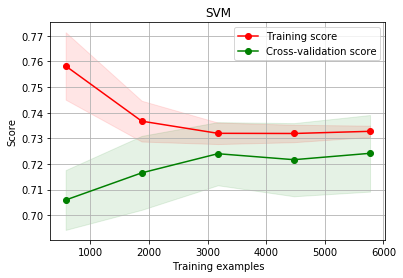

In [38]:
plt.figure()
plt.title("SVM")
plt.xlabel("Training examples")
plt.ylabel("Score")

train_sizes, train_scores, test_scores = learning_curve(fft_svm, X, y, cv=stratified_shuffle_split, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")

In [108]:
fft_random_forest = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=None, class_weight="balanced", n_jobs=-1, random_state=42)

In [109]:
fft_random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [103]:
fft_gradient_boosting = GradientBoostingClassifier(loss="deviance", learning_rate=0.1, n_estimators=100, max_depth=6, subsample=0.5, max_features="auto", criterion="friedman_mse")

In [104]:
fft_gradient_boosting.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [107]:
y_true = list(y_test)

In [147]:
y_pred = fft_svm.predict(X_test)

In [148]:
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")

In [149]:
print("acc: %.2f" % accuracy)
print("f1: %.2f" % f1)
print("precision: %.2f" % precision)
print("recall: %.2f" % recall)

acc: 0.73
f1: 0.73
precision: 0.75
recall: 0.73


In [272]:
# ALL DATA
fft_svm.fit(X, y)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=True)

In [278]:
# save the classifier
with open("3-gesture-fft-svm.pkl", "wb") as fid:
    pickle.dump(fft_svm, fid)

In [279]:
# load it again
with open("3-gesture-fft-svm.pkl", "rb") as fid:
    fft_svm = pickle.load(fid)

In [280]:
y_pred = fft_svm.predict(X_test)

In [281]:
accuracy = accuracy_score(y_true, y_pred)

In [282]:
accuracy

1.0